In [7]:
import sys; sys.path.insert(0, '../src')
%load_ext autoreload
%autoreload 2

In [8]:
import pandas as pd
import stumpy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.patches import Rectangle
import datetime as dt
import twopass
import changepoints
import tests

plt.rcParams["figure.figsize"] = [8, 3]  # width, height
plt.rcParams["figure.dpi"] = 300
plt.rcParams["font.family"] = "serif"
plt.rcParams['xtick.direction'] = 'in'
ids = changepoints.getIds()
eventLog = changepoints.readEventLog()
machineSet = list(changepoints.getMachines(eventLog))

C:\Python38\lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [56]:
def metricsMachine(machine, pen, window, algo, graph = False, start = True, end = True, method="Window", mode="dynamic", t=1000, repeatcalc=False):
    resbyday, logbyday = tests.checkpointsMatrixOrDTW(
      name = machine, 
      eventlog = eventLog, 
      ids = ids, 
      influx = False, 
      pen = pen, 
      window = window, 
      algo = algo, 
      interval = "5s", 
      template = "dba", 
      trimming = True, 
      firstpassmethod=method,
      mode=mode,
      t=t,
      debug = False
    )
    res = []
    for x in resbyday:
        daywiseX = []
        for y in x:
            if(start): daywiseX.append(y[0])
            if(end): daywiseX.append(y[1])
        res.append(daywiseX)

    metrics = tests.calculateMetrics(res, logbyday, start = start, end = end, customMargin=60)

    labels = list(map(lambda x: str(x["day"]), metrics))
    precision = list(map(lambda x: x["TP"] / (x["TP"] + x["FP"]) if x["TP"] != 0 else 0, metrics))
    recall = list(map(lambda x: x["TP"] / (x["TP"] + x["FN"]) if x["TP"] != 0 else 0, metrics))
    f1score = [2 * (p * r) / (p+r) if p != 0 else 0 for (p,r) in zip(precision, recall)]
    alldeviations = []
    for day in metrics:
        alldeviations += day["deviation"]

    if(repeatcalc):
        alldeviations = [] #Abuse alldeviations for all f1 scores
        for x in range(90):
            newmetrics = tests.calculateMetrics(res, logbyday, start = True, end = True, customMargin=90-x)
            prec = list(map(lambda x: x["TP"] / (x["TP"] + x["FP"]), newmetrics))
            prec = sum(prec)/len(prec)
            recall = list(map(lambda x: x["TP"] / (x["TP"] + x["FN"]), newmetrics))
            recall = sum(recall)/len(recall)
            f1 = 2*(prec * recall) / (prec + recall) if prec != 0 else 0
            alldeviations.append(f1)

    if(graph):

        x = np.arange(len(labels))  # the label locations
        width = 0.25  # the width of the bars

        fig, ax = plt.subplots()
        rects1 = ax.bar(x - width, precision, width, label='Prec.')
        rects2 = ax.bar(x + width, recall, width, label='Recall')
        rects3 = ax.bar(x, f1score, width, label="F1")

        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax.set_ylabel('Scores')
        ax.set_title('Scores by Day for ' + machine + " on " + algo)
        ax.set_xticks(x)
        ax.set_xticklabels(labels)
        ax.legend()

        ax.bar_label(rects1, padding=3)
        ax.bar_label(rects2, padding=3)
        ax.bar_label(rects3, padding=3)

        fig.tight_layout()
        plt.savefig("outmvd/metrics" + machine + mode + method + algo + ".png")
        plt.show()

        ## Histogram
        avgdev = sum(alldeviations)/len(alldeviations)

        plt.suptitle('Changepoint detection deviation, avg=' + str(avgdev))
        plt.xlabel('Time')
        plt.ylabel('Count')
        plt.hist(alldeviations, bins=30)
        plt.savefig("outmvd/deviation" + machine + mode + method + algo + ".png")
        plt.show()

    return metrics, precision, recall, f1score, alldeviations

# Compare with best parameters for MASS & DTW

In [58]:
import json

good_machines = ["HaasMM2", "Lasebox", "HaasST10", "cleanlaser", "Kasto"]
windows = [35, 20, 35, 35, 20]
pens = [10,0,10,10,10]
algos = ["Window"]
pass2algos = ["dtw", "matrix"]

oldres = {}

with open("out/res.json", "r") as infile:
  oldres = json.load(infile)

massT = {}

with open("outrvt/outresMassWindow/thresholdsMetrics.json", "r") as infile:
  massT = json.load(infile)

dtwT = {}

with open("outrvt/outresDTWWindow/thresholdsMetrics.json", "r") as infile:
  dtwT = json.load(infile)

threshs = {
  "dtw": dtwT,
  "matrix": dtwT
}

res = {}

for pass2 in pass2algos:

  res[pass2] = {
    "all": [],
    "starts": [],
    "ends": []
  }

  for ix in range(len(good_machines)):
    machine = good_machines[ix]
    window = windows[ix]

    metrics, precision, recall, f1score, alldeviations = metricsMachine(machine,pens[ix],window,pass2,False,True,True,"Window","statict",threshs[pass2][machine]["Window"][0])
    res[pass2]["all"].append((metrics, precision, recall, f1score, alldeviations))

    metrics, precision, recall, f1score, alldeviations = metricsMachine(machine,pens[ix],window,pass2,False,True,False,"Window","statict",threshs[pass2][machine]["Window"][0])
    res[pass2]["starts"].append((metrics, precision, recall, f1score, alldeviations))

    metrics, precision, recall, f1score, alldeviations = metricsMachine(machine,pens[ix],window,pass2,False,False,True,"Window","statict",threshs[pass2][machine]["Window"][0])
    res[pass2]["ends"].append((metrics, precision, recall, f1score, alldeviations))

with open("outmvd/res.json", "w") as outfile:
  json.dump(res, outfile)

Starting for HaasMM2
Day: 2020 06 24
104 zu 104
104
Kept 41 out of 42
Day: 2020 06 22
51 zu 51
51
Kept 20 out of 22
Day: 2020 06 25
106 zu 106
106
Kept 45 out of 48
Done with HaasMM2
WIE IST DAS MÖGLICH
Starting for HaasMM2
Day: 2020 06 24
104 zu 104
104
Kept 41 out of 42
Day: 2020 06 22
51 zu 51
51
Kept 20 out of 22
Day: 2020 06 25
106 zu 106
106
Kept 45 out of 48
Done with HaasMM2
Starting for HaasMM2
Day: 2020 06 24
104 zu 104
104
Kept 41 out of 42
Day: 2020 06 22
51 zu 51
51
Kept 20 out of 22
Day: 2020 06 25
106 zu 106
106
Kept 45 out of 48
Done with HaasMM2
Starting for Lasebox
Day: 2020 06 24
182 zu 182
182
Kept 47 out of 54
Day: 2020 06 22
77 zu 77
77
Kept 10 out of 12
Day: 2020 06 26
11 zu 11
11
Kept 8 out of 10
Day: 2020 06 25
209 zu 209
209
Kept 78 out of 83
Done with Lasebox
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
Starting for Lasebox
Da

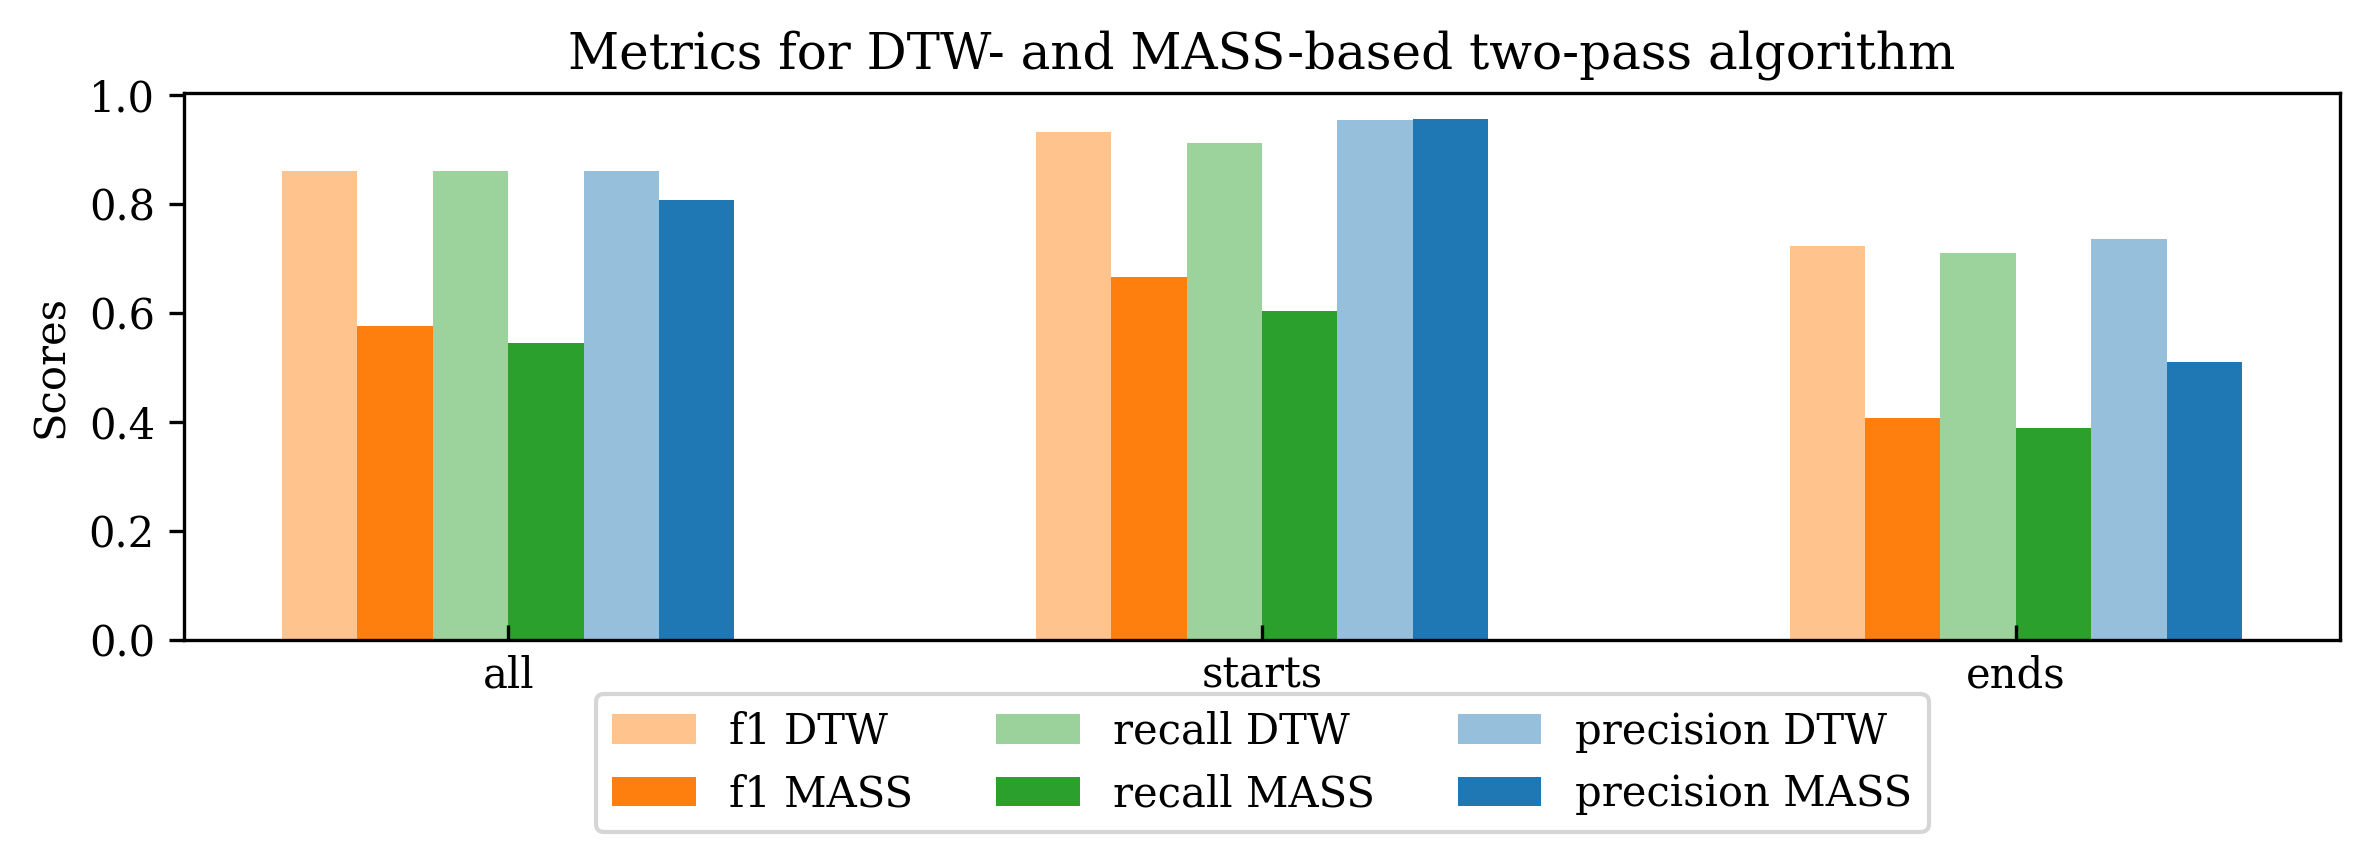

In [59]:
import json

good_machines = ["HaasMM2", "Lasebox", "HaasST10", "cleanlaser", "Kasto"]
windows = [35, 20, 35, 35, 20]
pens = [10,0,10,10,10]
algos = ["Window"]
pass2algos = ["dtw", "matrix"]
configs = ["all", "starts", "ends"]

res = {}

with open("outmvd/res.json", "r") as infile:
  res = json.load(infile)

vis = {
  "dtw": {},
  "matrix": {}
}

for pass2 in pass2algos:

  vis[pass2] = {
    "recall": {},
    "precision": {},
    "f1": {},
    "deviations": {}
  }

  for config in configs:
    vis[pass2]["f1"][config] = sum([sum(x[3])/len(x[3]) for x in res[pass2][config]])/len([x[3] for x in res[pass2][config]])

    vis[pass2]["recall"][config] = sum([sum(x[2])/len(x[2]) for x in res[pass2][config]])/len([x[2] for x in res[pass2][config]])

    vis[pass2]["precision"][config] = sum([sum(x[1])/len(x[1]) for x in res[pass2][config]])/len([x[1] for x in res[pass2][config]])

    vis[pass2]["deviations"][config] = sum([x[4] for x in res[pass2][config]], [])


def choosecolor(algo):
  if algo == "f1 dtw":
    return ["#FF7F0E77"]
  elif algo == "f1 mass":
    return ["#FF7F0Eff"]
  elif algo == "recall dtw":
    return ["#2CA02C77"]
  elif algo == "recall mass":
    return ["#2CA02Cff"]
  elif algo == "precision dtw":
    return ["#1F77B477"] 
  elif algo == "precision mass":
    return ["#1F77B4ff"]
  else:
    return ""

x = np.arange(len(configs))  # the label locations
width = 0.1  # the width of the bars

fig, ax = plt.subplots()
for ix, metric in enumerate(["f1", "recall", "precision"]):

  dtwstuff = [vis["dtw"][metric][s] for s in configs]

  massstuff = [vis["matrix"][metric][s] for s in configs]


  rects1 = ax.bar(x + (width * (ix - 1))*2 - width/2, dtwstuff, width, label=metric + " DTW", color=choosecolor(metric + " dtw"))
  rects3 = ax.bar(x + (width * (ix - 1))*2 + width/2, massstuff, width, label=metric + " MASS", color=choosecolor(metric + " mass"))

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Metrics for DTW- and MASS-based two-pass algorithm')
ax.set_xticks(x)
ax.set_xticklabels(configs)
ax.legend(ncol=3, fancybox=True,loc="upper center", bbox_to_anchor=(0.5, -0.06))

fig.tight_layout()

plt.savefig("./outmvd/BarChart.png")
plt.show()



In [61]:
import json
import statistics

good_machines = ["HaasMM2", "Lasebox", "HaasST10", "cleanlaser", "Kasto"]
windows = [35, 20, 35, 35, 20]
pens = [10,0,10,10,20]
algos = ["Window"]
pass2algos = ["dtw", "matrix"]
configs = ["all", "starts", "ends"]

oldres = {}

with open("out/res.json", "r") as infile:
  oldres = json.load(infile)

massT = {}

with open("outrvt/outresMassWindow/thresholdsMetrics.json", "r") as infile:
  massT = json.load(infile)

dtwT = {}

with open("outrvt/outresDTWWindow/thresholdsMetrics.json", "r") as infile:
  dtwT = json.load(infile)

threshs = {
  "dtw": dtwT,
  "matrix": dtwT
}

totaldeviations = {}
for pass2 in pass2algos:
  totaldeviations[pass2] = {}
  for config in configs:
    totaldeviations[pass2][config] = []

    for ix in range(len(good_machines)):
      machine = good_machines[ix]
      window = windows[ix]
      for algo in algos:
        metrics, precision, recall, f1score, alldeviations = metricsMachine(machine,pens[ix],window,pass2,False,config=="all" or config == "starts",config=="all" or config == "ends",algo,"statict",threshs[pass2][machine]["Window"][0], True)
        if(len(totaldeviations[pass2][config]) == 0):
          totaldeviations[pass2][config] = alldeviations
        else:
          totaldeviations[pass2][config] = [sum(x) for x in zip(totaldeviations[pass2][config], alldeviations)]
        print(algo + "DONE")
    totaldeviations[pass2][config] = [x/len(good_machines) for x in totaldeviations[pass2][config]]

Starting for HaasMM2
Day: 2020 06 24
104 zu 104
104
Kept 41 out of 42
Day: 2020 06 22
51 zu 51
51
Kept 20 out of 22
Day: 2020 06 25
106 zu 106
106
Kept 45 out of 48
Done with HaasMM2
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WindowDONE
Starti

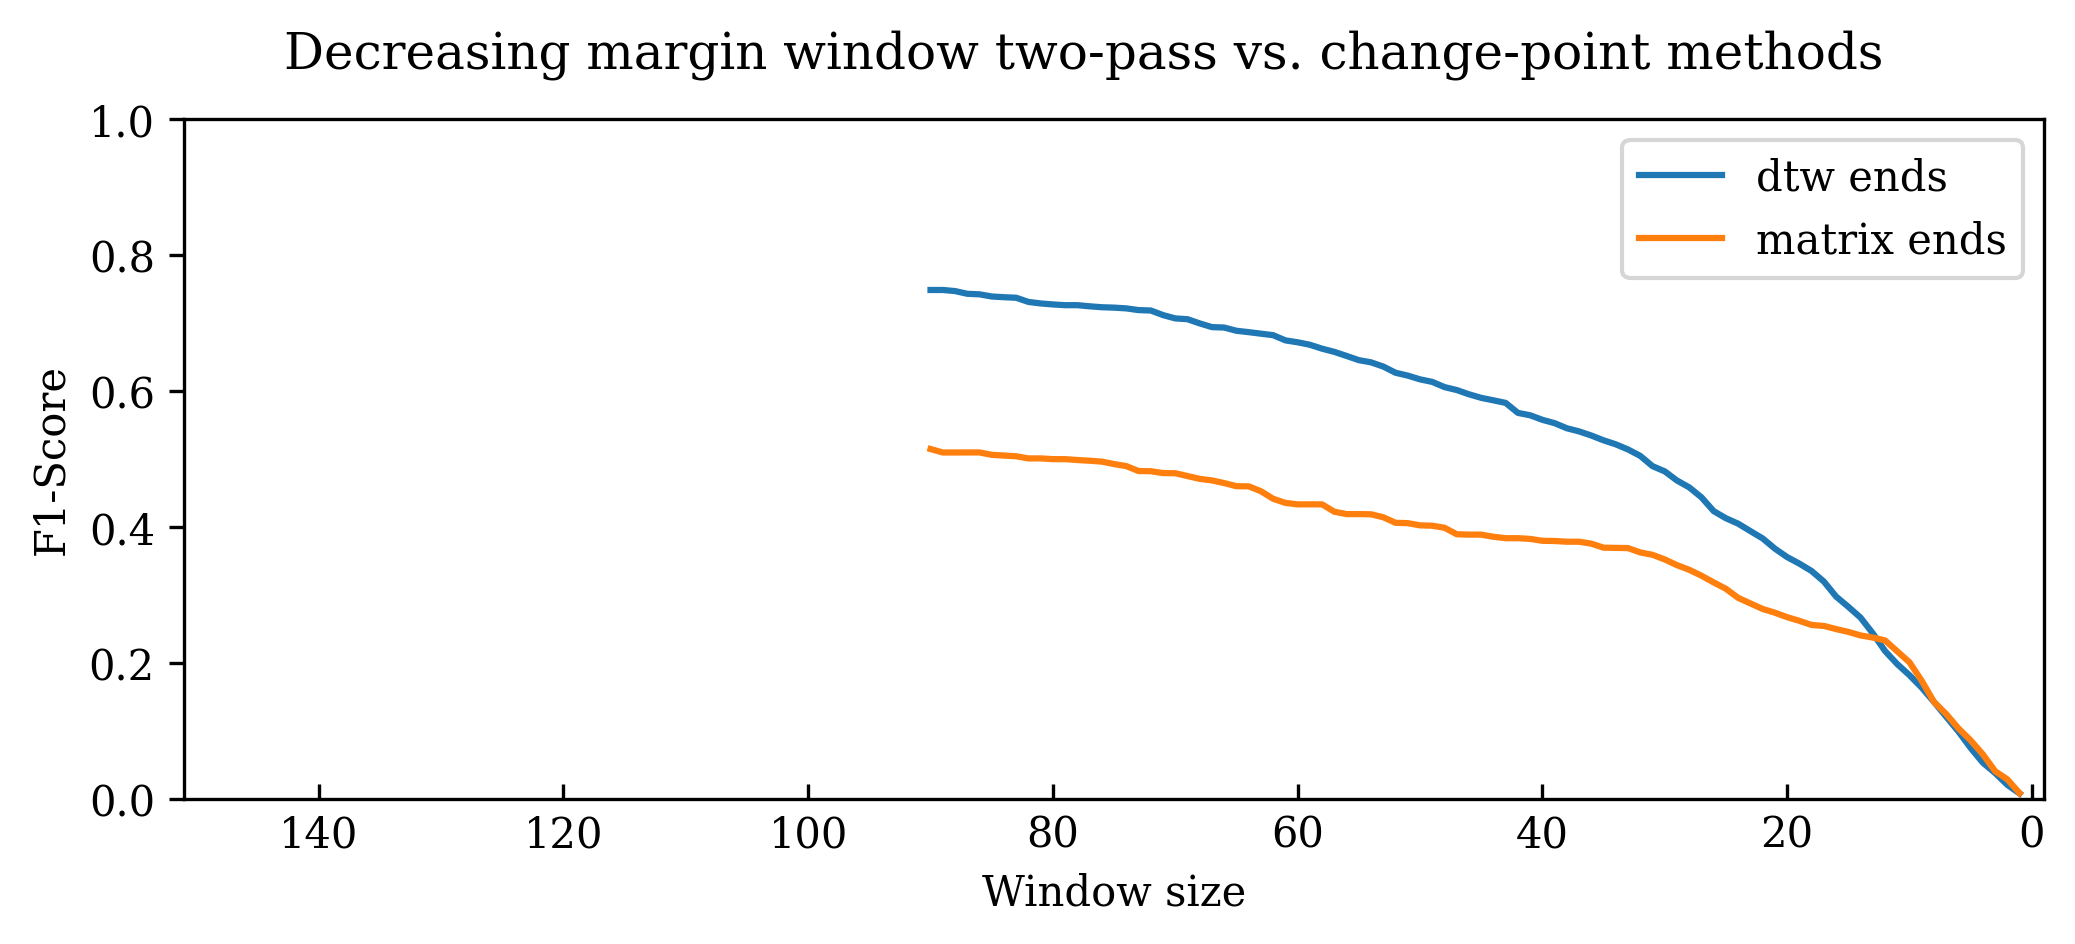

In [63]:
plt.suptitle("Decreasing margin window two-pass vs. change-point methods")
plt.xlabel('Window size')
plt.ylabel('F1-Score')
for pass2 in pass2algos:
  for config in ["ends"]:
    plt.plot([90-x for x in range(90)], totaldeviations[pass2][config], label=pass2 + " " + config)
plt.legend()
plt.xlim(91,-1)
plt.ylim(0,1)
#plt.xticks(range(len(pens)), pens, rotation=45)
#plt.savefig("./outrvt/outresDTWWindow/F1score" + good_machines[ix] + ".png")
plt.show()

20.895359741714103


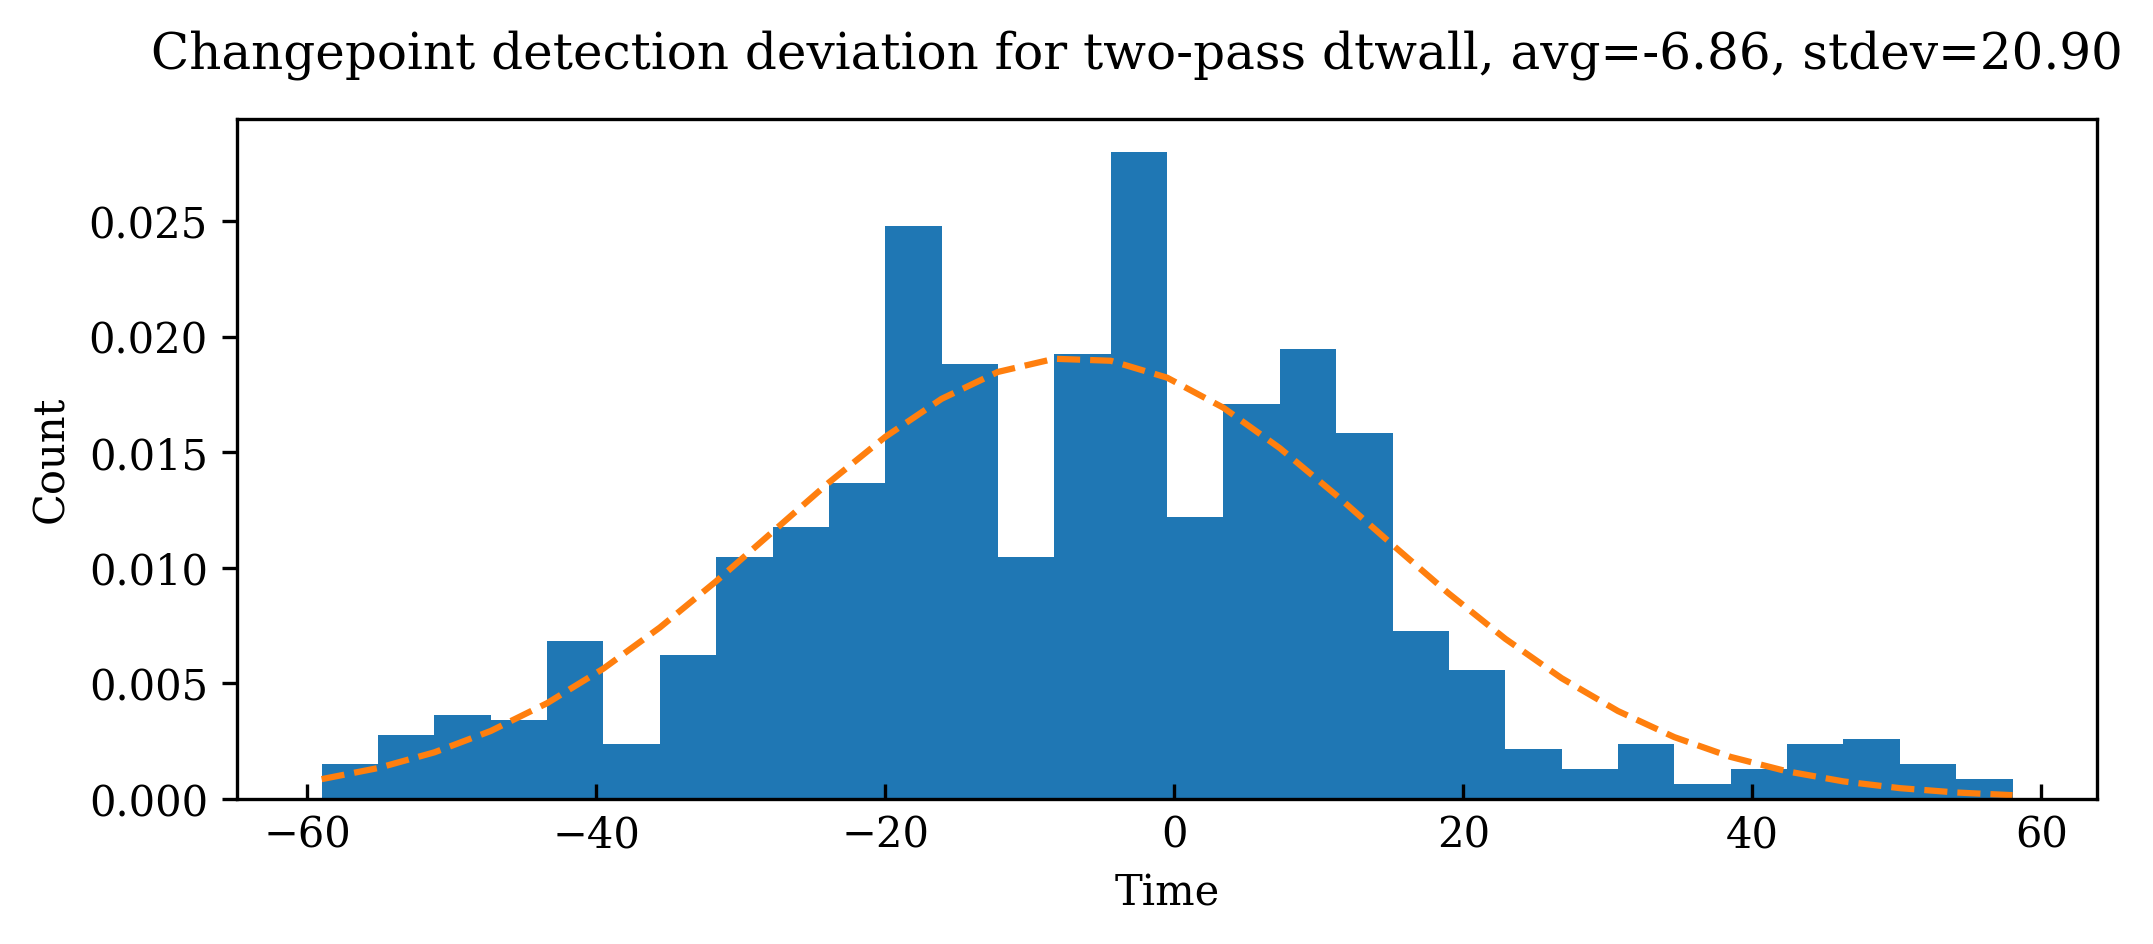

19.556106373497045


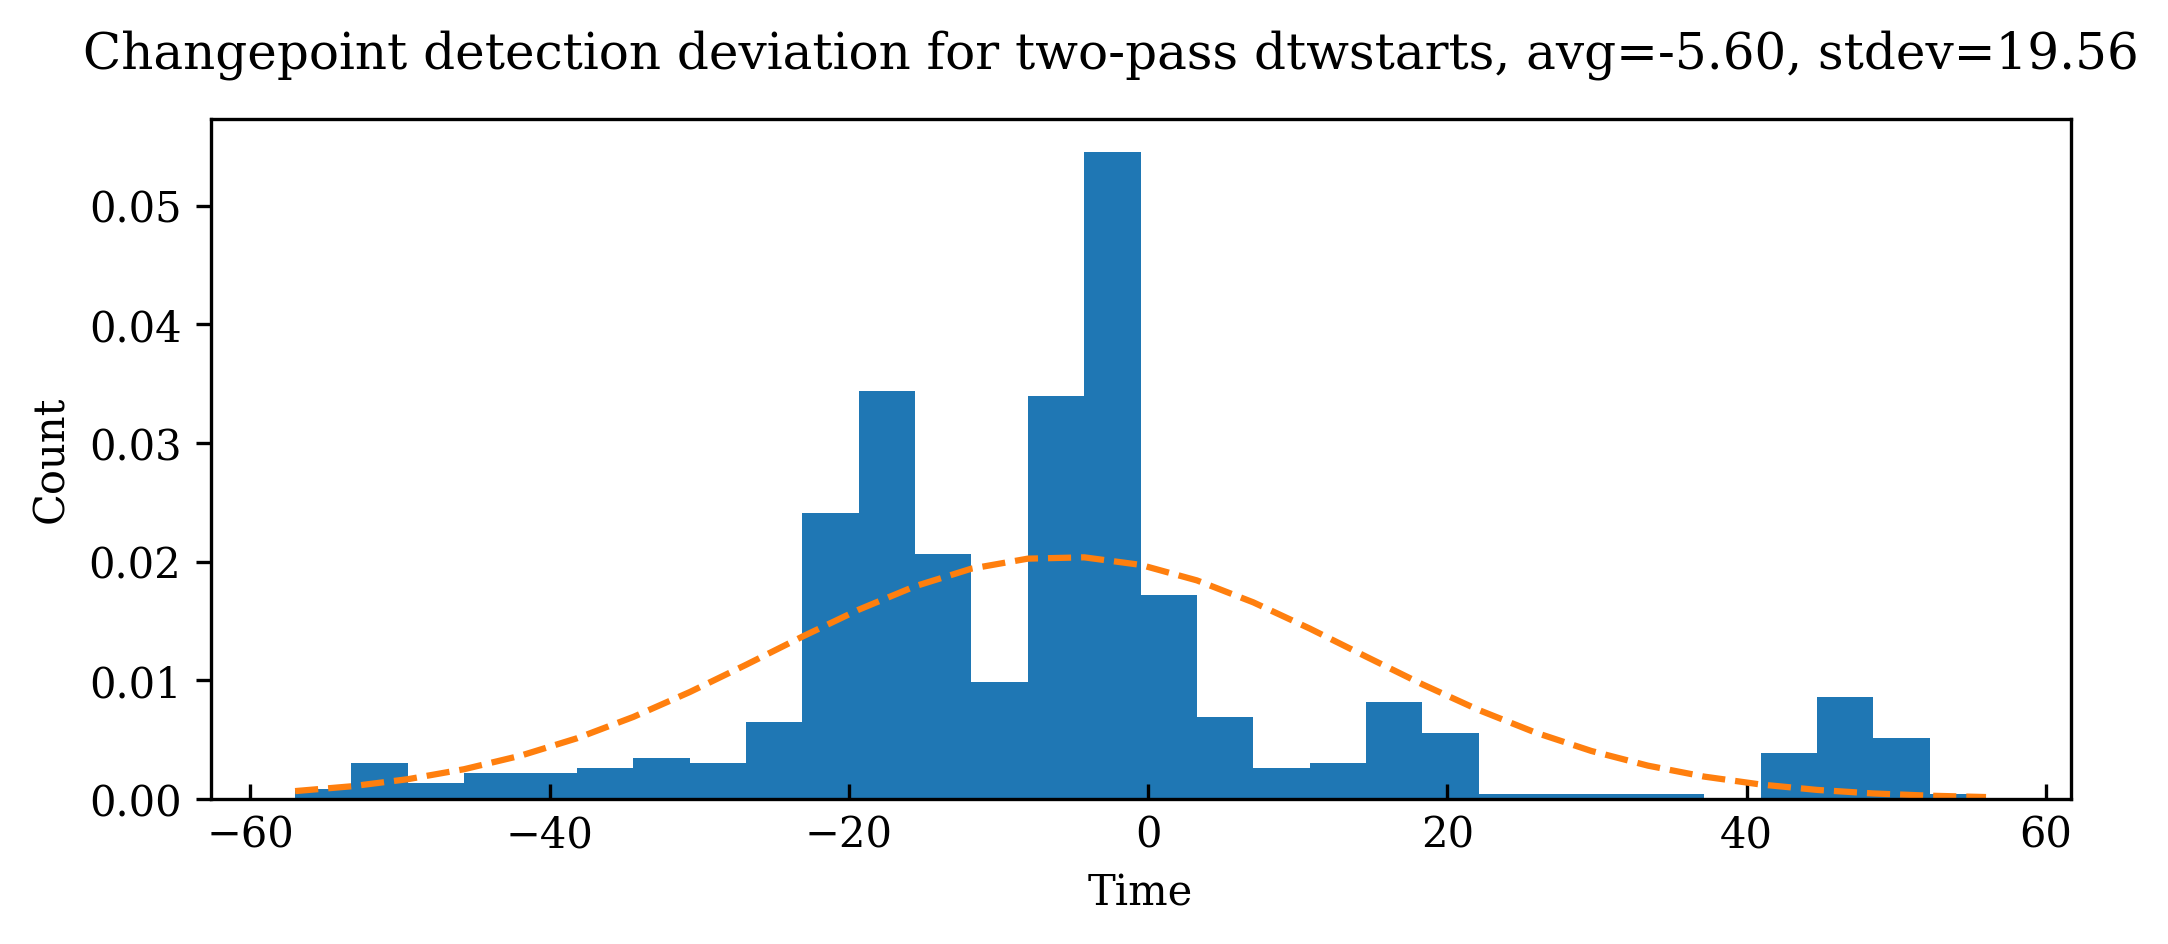

22.393294285232496


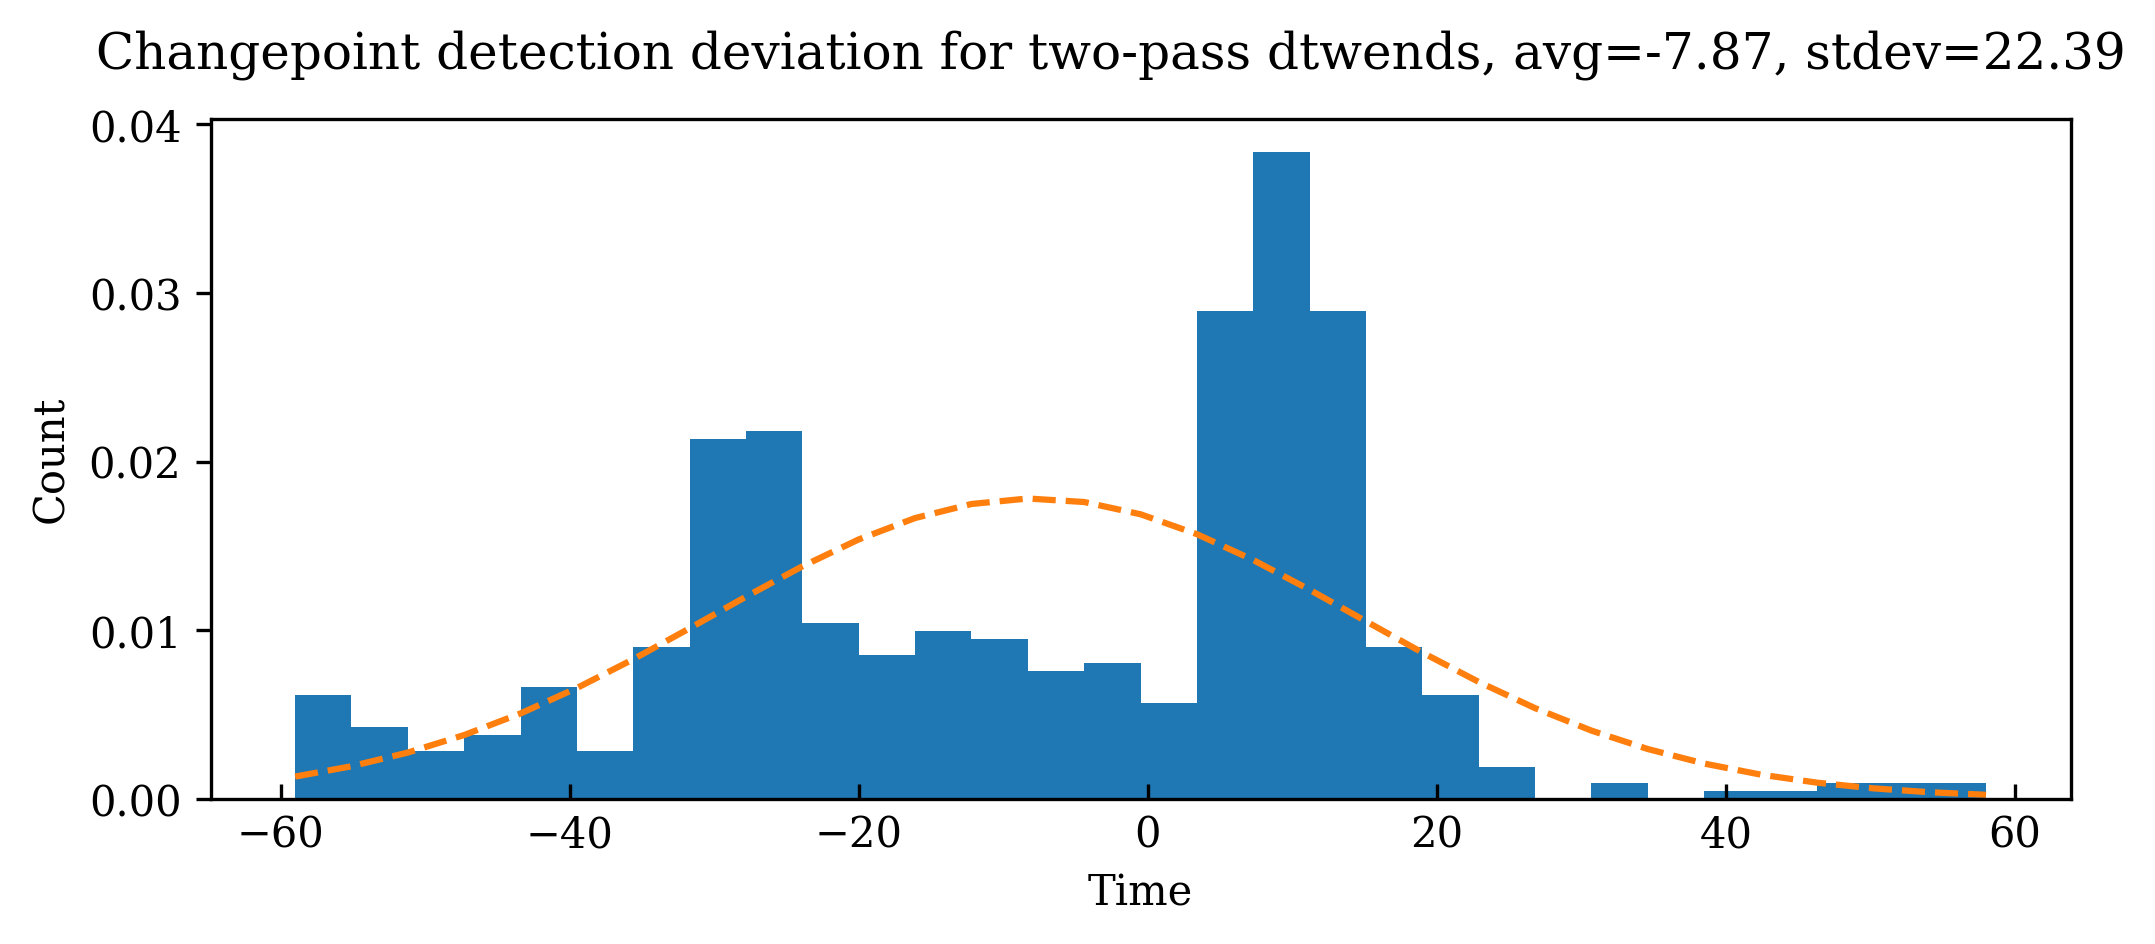

18.045216020859755


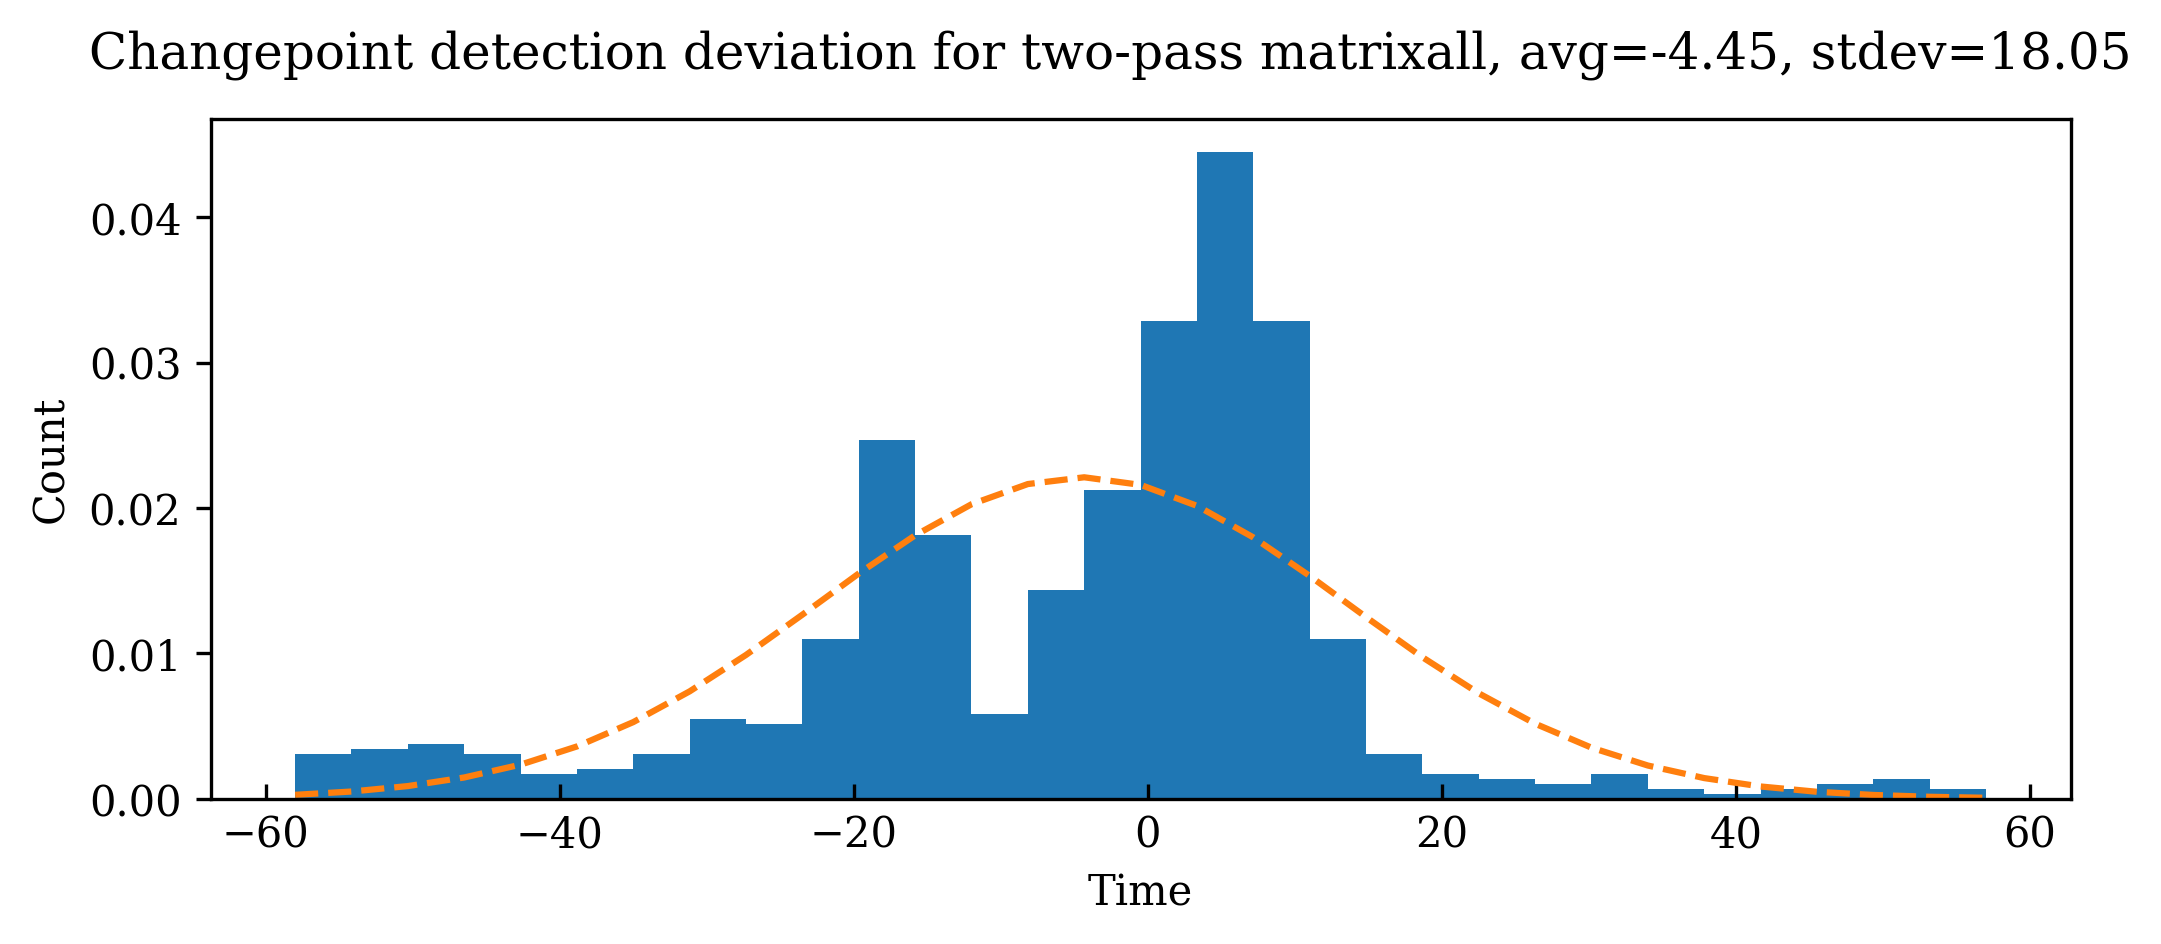

15.59843129714487


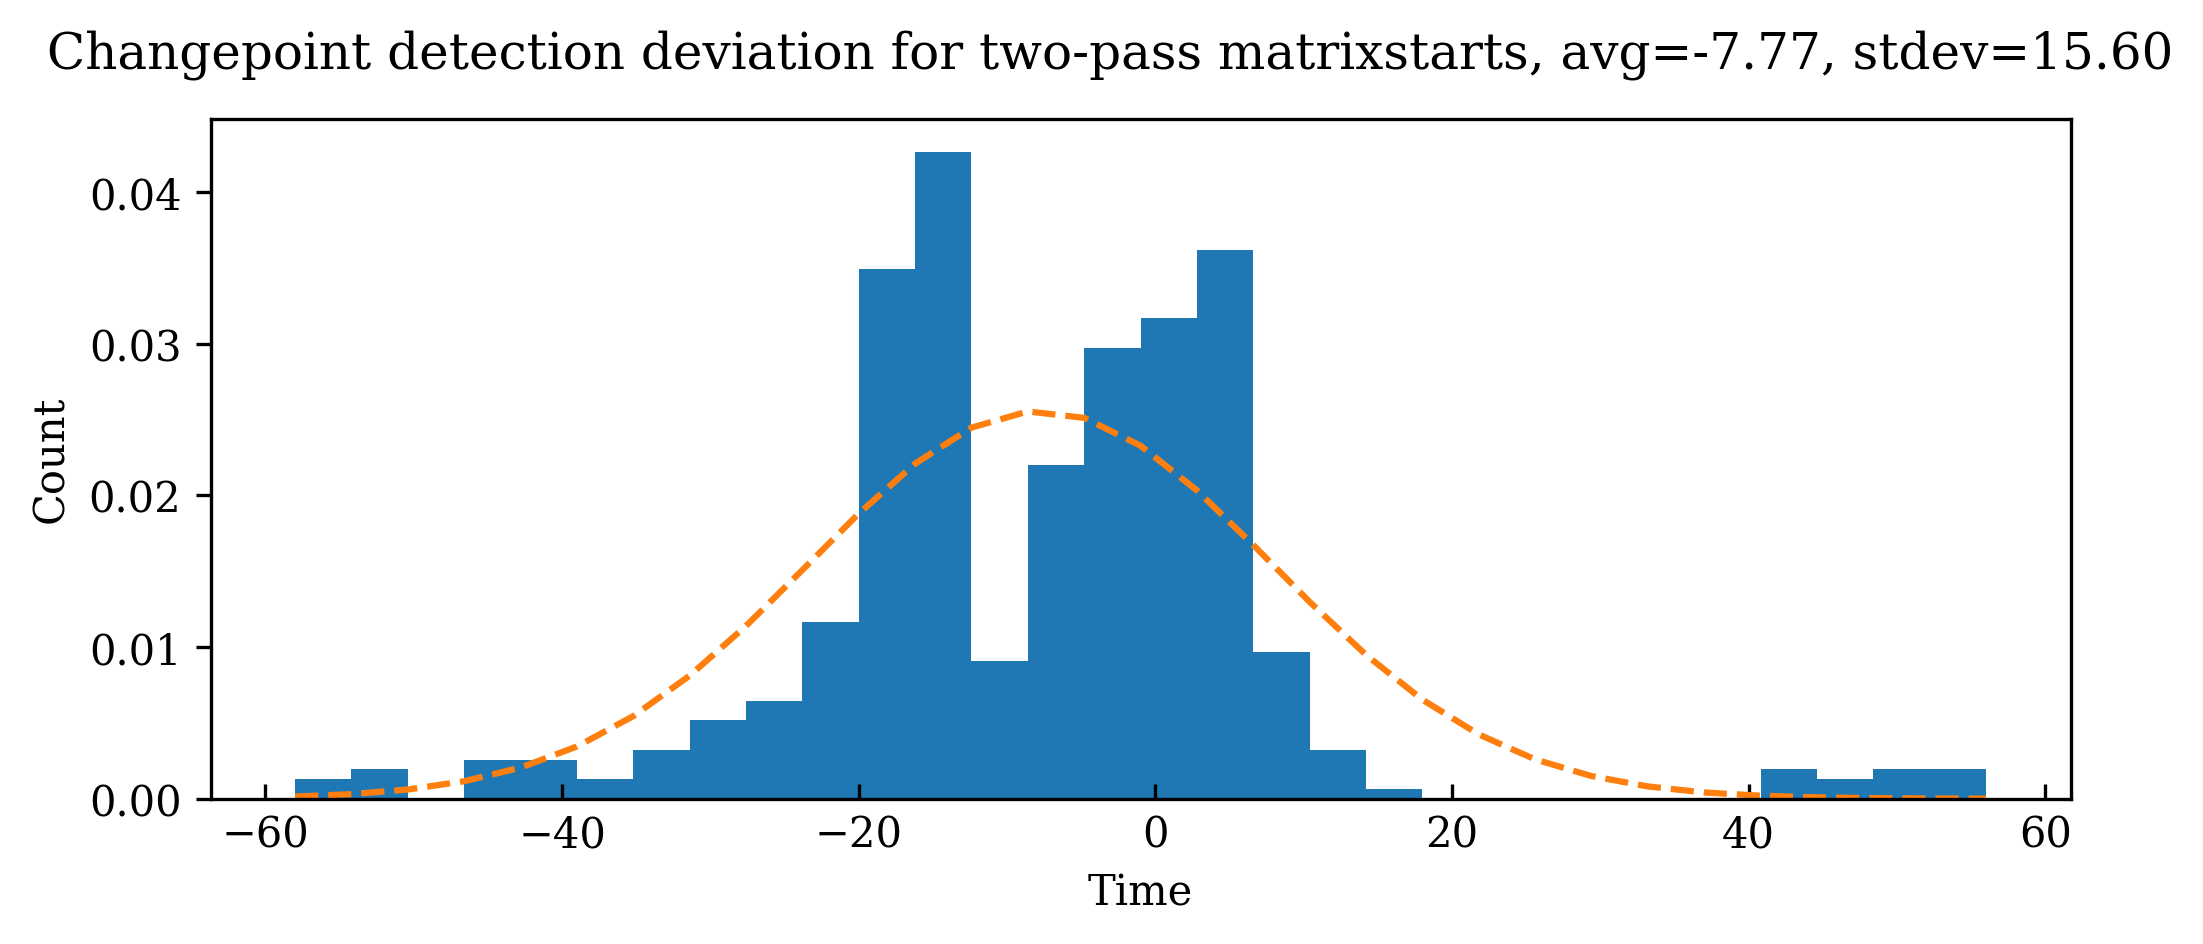

17.31029634339247


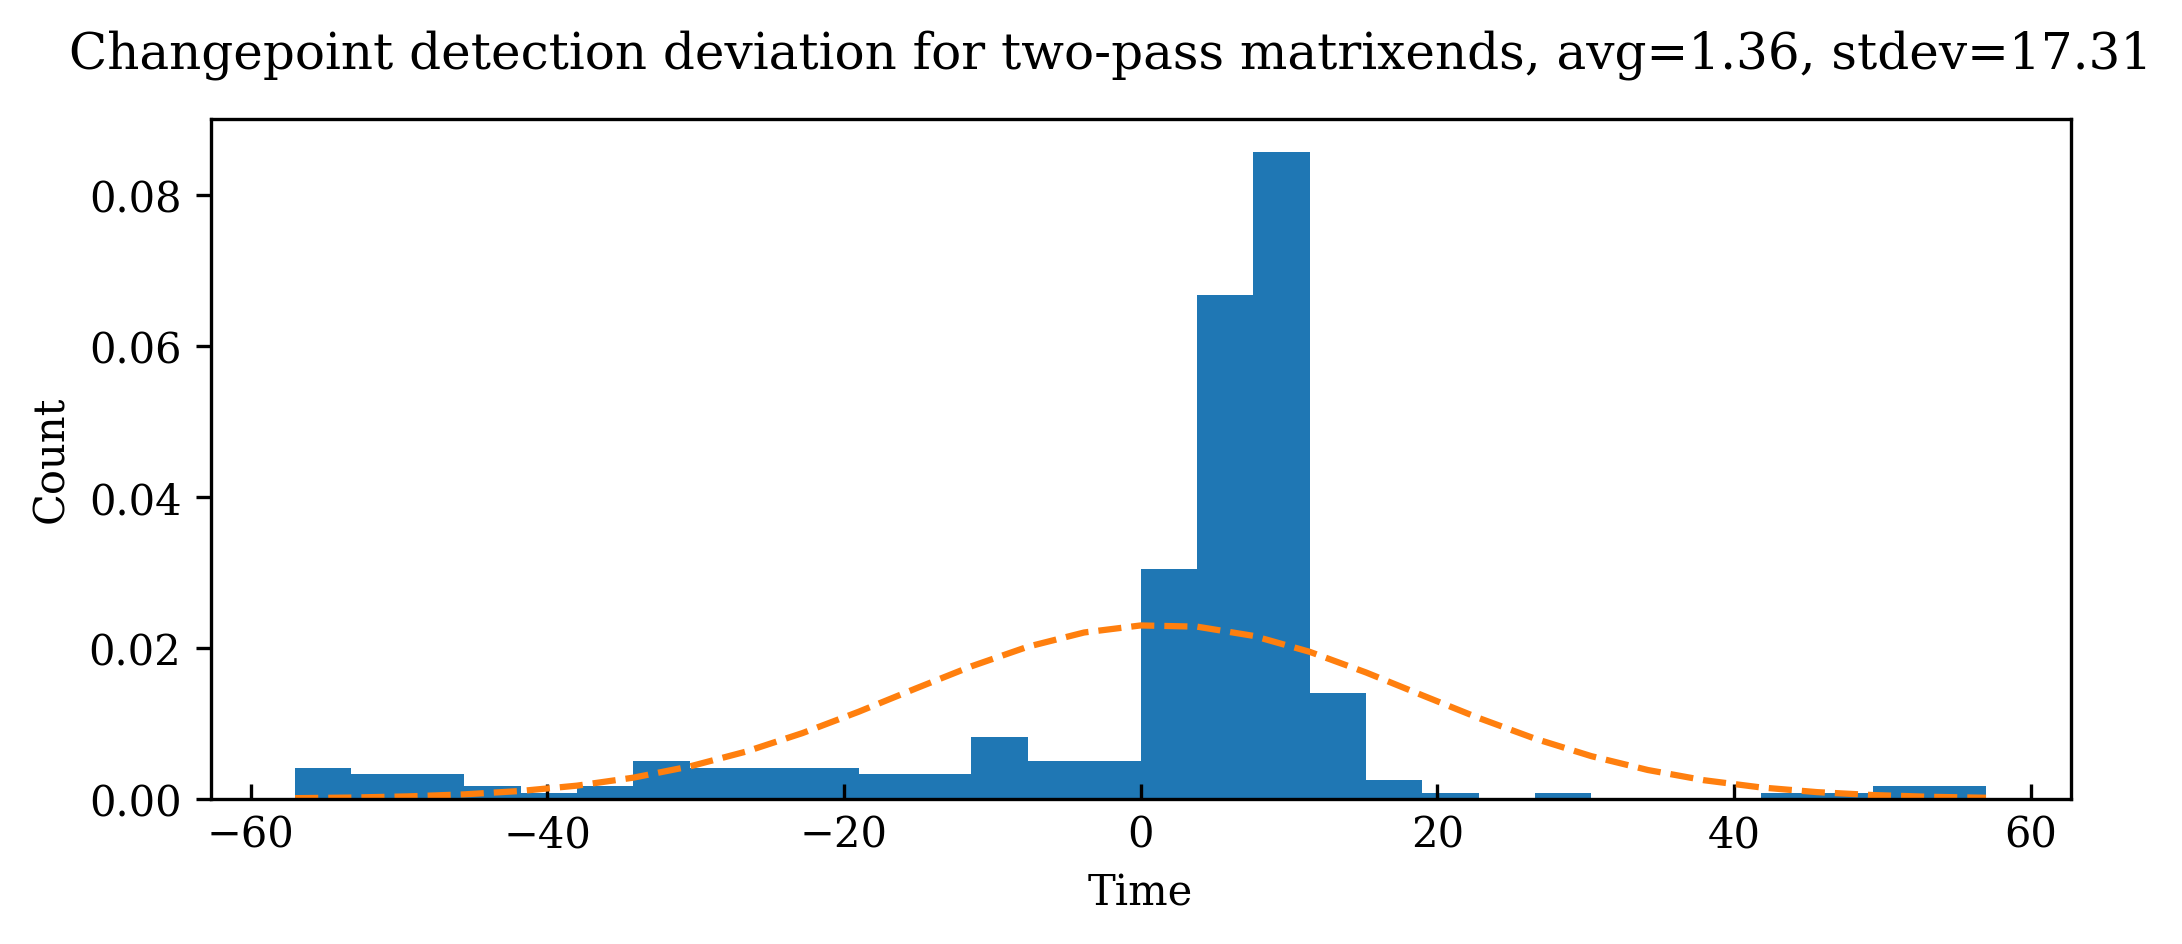

In [60]:
import statistics
import numpy as np

for pass2 in pass2algos:
  for config in configs:

    deviations = vis[pass2]["deviations"][config]

    avgdev = sum(deviations)/len(deviations)
    stddev = statistics.stdev(deviations)

    print(stddev)

    plt.suptitle('Changepoint detection deviation for two-pass ' + pass2 + config +', avg=' + "{:.2f}".format(avgdev) + ", stdev=" + "{:.2f}".format(stddev))
    plt.xlabel('Time')
    plt.ylabel('Count')
    n, bins, patches = plt.hist(deviations, bins=30, density=True)

    y = ((1 / (np.sqrt(2 * np.pi) * stddev)) * np.exp(-0.5 * (1 / stddev * (bins - avgdev))**2))

    plt.plot(bins, y, "--")
    #plt.savefig("outrvt/deviation" + machine + mode + method + algo + ".png")
    plt.show()